main code and inspiration by [Jaykef_](https://x.com/Jaykef_)

## Features Missing or Divergent from the Paper

### Entropy-Based Patching

The paper describes dynamic patching using entropy thresholds for optimal segmentation. Your code uses fixed patch sizes (`patch_size = 4`) and lacks entropy calculations or dynamic adjustments.

In [3]:

import torch  
import torch.nn as nn  
import torch.nn.functional as F  
import math  
import time  
import matplotlib.pyplot as plt  


# Hyperparameter definitions
batch_size = 8              # Number of sequences processed together
block_size = 1024           # Maximum sequence length in bytes
patch_size = 4              # Number of bytes per patch for the model
num_iters = 2000            # Total training iterations
learning_rate = 1e-3        # Learning rate for the optimizer
n_embd = 128                # Dimensionality of byte embeddings
n_head = 2                  # Number of attention heads in multihead attention
n_layers_encoder = 2        # Number of layers in the encoder
n_layers_latent = 4         # Number of layers in the latent transformer
n_layers_decoder = 2        # Number of layers in the decoder
dropout = 0.1               # Dropout rate for regularization
vocab_size = 256            # Number of unique byte values (0-255)
hash_sizes = range(3, 6)    # Sizes of n-grams for hashing (3-grams, 4-grams, 5-grams)
hash_table_size = 50000     # Hash table size for n-gram embeddings


In [4]:
class LayerNorm(nn.Module):
    """Custom implementation of Layer Normalization to stabilize training."""
    def __init__(self, ndim, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))  
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None  

    def forward(self, x):
        # Apply layer normalization with learned parameters
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)


In [5]:
class Block(nn.Module):
    """Defines a Transformer block with self-attention and feed-forward layers."""
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        # Layer normalization applied before attention
        self.ln1 = LayerNorm(n_embd)
        # Multihead attention for capturing relationships between byte embeddings
        self.attn = nn.MultiheadAttention(embed_dim=n_embd, num_heads=n_head, dropout=dropout, batch_first=True)
        # Second layer normalization applied before the feed-forward network
        self.ln2 = LayerNorm(n_embd)
        # Feed-forward network with non-linearity and dropout for regularization
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand dimensionality
            nn.GELU(),  # Activation function
            nn.Linear(4 * n_embd, n_embd),  # Reduce dimensionality
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Apply self-attention and add the residual connection
        attn_out, _ = self.attn(self.ln1(x), self.ln1(x), self.ln1(x))
        x = x + attn_out
        # Apply feed-forward network and add the residual connection
        x = x + self.mlp(self.ln2(x))
        return x


* This block forms the building unit of the Transformer, alternating between self-attention and feed-forward layers.
* Residual connections help mitigate vanishing gradient issues.

In [6]:
class CrossAttentionLayer(nn.Module):
    """Facilitates interaction between query and key-value representations."""
    def __init__(self, query_dim, key_dim, n_head, dropout):
        super().__init__()
        # Layer normalization for query and key-value inputs
        self.ln_q = LayerNorm(query_dim)
        self.ln_kv = LayerNorm(key_dim)
        # Multihead attention for cross-attention
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=n_head, dropout=dropout, batch_first=True)
        # Linear projection to project back to query dimensionality
        self.proj = nn.Linear(query_dim, query_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        # Normalize inputs
        query = self.ln_q(query)
        key = self.ln_kv(key)
        value = self.ln_kv(value)
        # Compute cross-attention
        attn_out, _ = self.attn(query, key, value)
        # Apply projection and dropout, then add residual connection
        attn_out = self.proj(attn_out)
        attn_out = self.dropout(attn_out)
        return query + attn_out


In [7]:
class HashNGramEmbedding(nn.Module):
    """Implements n-gram hashing and embedding for byte sequences."""
    def __init__(self, hash_sizes, hash_table_size, n_embd):
        super().__init__()
        self.hash_sizes = hash_sizes  # Range of n-gram sizes
        self.hash_table_size = hash_table_size  # Size of hash table
        self.n_embd = n_embd  # Embedding size for each n-gram
        # Embedding layers for each n-gram size
        self.hash_embeddings = nn.ModuleDict({
            f"hash_{n}": nn.Embedding(hash_table_size, n_embd) for n in hash_sizes
        })

    def forward(self, x):
        B, T = x.shape
        # Initialize zero embeddings
        embeddings = torch.zeros(B, T, self.n_embd, device=x.device)
        # Process each n-gram size
        for n in self.hash_sizes:
            if T < n:  # Skip if sequence is too short
                continue
            # Extract n-grams as sliding windows
            ngrams = x.unfold(1, n, 1)  # [B, T - n + 1, n]
            # Compute hash values for n-grams
            hashes = self.roll_poly_hash(ngrams) % self.hash_table_size
            # Lookup embeddings for each hash
            hash_emb = self.hash_embeddings[f"hash_{n}"](hashes)
            # Scatter-add embeddings into the sequence
            embeddings[:, n-1:T, :] += hash_emb
        # Normalize by the number of hash sizes
        embeddings /= len(self.hash_sizes)
        return embeddings

    def roll_poly_hash(self, ngrams):
        """Computes a rolling hash for n-grams."""
        base = 257
        hash_val = torch.zeros(ngrams.size(0), ngrams.size(1), device=ngrams.device, dtype=torch.long)
        for i in range(ngrams.size(2)):  # For each byte in the n-gram
            hash_val = (hash_val * base + ngrams[:, :, i].long()) % (2**32)
        return hash_val


* Encodes byte sequences into hash-based embeddings for compact representation.
* Uses polynomial rolling hashes for efficient n-gram embedding lookups.

In [8]:
class LocalEncoder(nn.Module):
    """Encodes input byte sequences into compact patch representations."""
    def __init__(self, vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, lE):
        super().__init__()
        self.patch_size = patch_size  # Size of each patch
        # Byte-level embedding layer
        self.byte_embedding = nn.Embedding(vocab_size, n_embd)
        # Hash-based n-gram embedding layer
        self.hash_ngram = HashNGramEmbedding(hash_sizes, hash_table_size, n_embd)
        # Transformer layers for local processing
        self.transformer_blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(lE)])
        # Cross-attention layer for pooling information into patches
        self.cross_attn = CrossAttentionLayer(n_embd, n_embd, n_head, dropout)
        # Final layer normalization
        self.ln = LayerNorm(n_embd)

    def forward(self, x):
        B, T = x.shape  # Batch size (B) and sequence length (T)
        # Convert bytes into embeddings
        x_emb = self.byte_embedding(x)
        # Add hash-based n-gram embeddings
        hash_emb = self.hash_ngram(x)
        x_emb += hash_emb

        # Pass through local Transformer layers
        for block in self.transformer_blocks:
            x_emb = block(x_emb)

        # Handle padding to ensure complete patches
        if T % self.patch_size != 0:
            pad_len = self.patch_size - (T % self.patch_size)
            pad = torch.zeros((B, pad_len), dtype=x.dtype, device=x.device).long()
            pad_emb = self.byte_embedding(pad) + self.hash_ngram(pad)
            x_emb = torch.cat([x_emb, pad_emb], dim=1)
            T += pad_len

        # Reshape into patches and pool their representations
        patches = x_emb.view(B, T // self.patch_size, self.patch_size, -1).mean(dim=2)
        # Use cross-attention to refine patches
        patches = self.cross_attn(patches, x_emb, x_emb)
        return self.ln(patches)  # Return normalized patches


## Purpose

The Local Encoder processes raw byte-level input sequences and converts them into patch representations. These patches are compact, context-aware embeddings that serve as inputs to the next module, the Latent Transformer.

## Key Steps

1. **Byte Embedding**: Each byte is converted into a fixed-dimensional embedding vector.
2. **Hash-Based n-Gram Embeddings**: Local context is captured by hashing n-grams and adding their embeddings to the byte embeddings.
3. **Transformer Layers**: A series of Transformer blocks further refine the representations by modeling relationships within the sequence.
4. **Padding**: Ensures that sequences are divisible into patches by adding zero-padding where necessary.
5. **Patch Pooling**: The sequence is divided into non-overlapping patches, and the embeddings within each patch are averaged to create a compact representation.
6. **Cross-Attention**: Enhances patches by allowing them to attend to the original sequence, improving contextual information.

## Intuition

This module compresses raw byte sequences into smaller, information-rich patches that are easier to process by the Latent Transformer.

In [9]:
class LocalDecoder(nn.Module):
    """Decodes latent patch representations back into byte sequences."""
    def __init__(self, vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, lD):
        super().__init__()
        self.patch_size = patch_size  # Size of patches
        # Hash-based n-gram embedding layer
        self.hash_ngram = HashNGramEmbedding(hash_sizes, hash_table_size, n_embd)
        # Cross-attention layer for integrating patch information
        self.cross_attn = CrossAttentionLayer(n_embd, n_embd, n_head, dropout)
        # Local Transformer layers for refinement
        self.transformer_blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(lD)])
        # Projection layer to map to byte space
        self.byte_proj = nn.Linear(n_embd, patch_size * vocab_size)
        # Final layer normalization
        self.ln = LayerNorm(vocab_size)

    def forward(self, x, patches):
        # Apply cross-attention using patches as keys and values
        x = self.cross_attn(x, patches, patches)

        # Pass through local Transformer layers
        for block in self.transformer_blocks:
            x = block(x)

        # Project the output to the byte space
        x = self.byte_proj(x)
        B, T_patches, _ = x.shape
        # Reshape to return the byte sequence
        return self.ln(x.view(B, T_patches * self.patch_size, -1))


## Purpose

The Local Decoder takes the global patch representations from the Latent Transformer and reconstructs the original byte sequence.

## Key Steps

1. **Cross-Attention**: Uses patches as keys and values to refine the byte-level representations. This ensures the decoded output remains consistent with the patches' information.
2. **Transformer Layers**: Adds further refinements to the sequence representations.
3. **Projection to Bytes**: Maps the refined representations back into the byte space using a linear projection.
4. **Reshaping**: Converts the output from patch space into a continuous byte sequence.

## Intuition

This module decodes the latent information back into a byte-level format, completing the end-to-end process.

In [10]:
class LatentTransformer(nn.Module):
    """Processes patches through multiple Transformer layers to capture global dependencies."""
    def __init__(self, n_embd, n_head, n_layers, dropout):
        super().__init__()
        # Stack of Transformer blocks
        self.blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(n_layers)])
        # Final layer normalization
        self.ln_f = LayerNorm(n_embd)

    def forward(self, x):
        # Pass the input through each Transformer block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        return self.ln_f(x)


## Purpose

The Latent Transformer processes the patches produced by the Local Encoder. It models long-range dependencies across patches, allowing the model to capture relationships between distant parts of the input.

## Key Steps

1. **Transformer Blocks**: Multiple Transformer blocks stack to progressively refine the patch representations.
2. **Global Context**: Unlike the Local Encoder, which focuses on nearby relationships, the Latent Transformer is designed to understand the global structure across patches.

## Intuition

This module acts as the brain of the model, aggregating information from patches and creating globally coherent representations.

In [11]:
class ByteLatentTransformer(nn.Module):
    """Combines encoder, latent transformer, and decoder into a single end-to-end model."""
    def __init__(self, vocab_size, n_embd, n_head, n_layers_encoder, n_layers_latent, n_layers_decoder, dropout, patch_size, hash_sizes, hash_table_size, block_size):
        super().__init__()
        # Local encoder for byte-to-patch conversion
        self.local_encoder = LocalEncoder(vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, n_layers_encoder)
        # Latent transformer for processing patch representations
        self.latent_transformer = LatentTransformer(n_embd, n_head, n_layers_latent, dropout)
        # Local decoder for reconstructing byte sequences
        self.local_decoder = LocalDecoder(vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, n_layers_decoder)
        # Positional embeddings for patches
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size // patch_size, n_embd))
        # Initialize model weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        # Encode input byte sequence into patches
        patches = self.local_encoder(x)
        # Add positional embeddings to patches
        patches += self.pos_embedding[:, :patches.size(1), :]

        # Process patches through the latent transformer
        transformed_patches = self.latent_transformer(patches)

        # Decode the patches back into byte sequences
        logits = self.local_decoder(transformed_patches, patches)

        # Optionally compute loss if targets are provided
        if targets is not None:
            B, T, _ = logits.shape
            loss = F.cross_entropy(logits.view(B * T, -1), targets.view(-1))
            return logits, loss
        return logits, None


## Purpose

Combines the Local Encoder, Latent Transformer, and Local Decoder into a single, cohesive architecture for end-to-end processing.

## Key Features

- **Positional Embeddings**: Adds positional information to patches to preserve the order of bytes within the sequence.
- **End-to-End Design**: From raw byte input to reconstructed byte output, this model is fully integrated.
- **Loss Calculation**: Optionally calculates cross-entropy loss during training when target sequences are provided.

## Intuition

BLT is the full model pipeline that compresses, processes, and reconstructs byte sequences. It balances local and global processing, enabling it to handle tasks like compression, language modeling, and sequence generation efficiently.

In [25]:
class PrepData:
    """Dataset handling byte-level text data."""
    def __init__(self, text, block_size, patch_size):
        self.data = torch.frombuffer(text.encode('utf-8'), dtype=torch.uint8)
        self.block_size = block_size
        self.patch_size = patch_size
        assert self.block_size % self.patch_size == 0, "block_size must be divisible by patch_size."

    def __len__(self):
        return len(self.data) - self.block_size - self.patch_size + 1

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + self.patch_size]
        x = chunk[:self.block_size].long()
        y = chunk[1:self.block_size + 1].long()  # Changed to next byte
        return x, y

def bits_per_byte(loss):
    """Calculate Bits-Per-Byte (BPB)."""
    return loss / math.log(2)

def train_model():
    # Setup device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')

    # Load data
    try:
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print("Error: 'input.txt' not found. Please ensure the file exists in the 'data' directory.")
        return None, None

    # Data statistics
    raw_bytes = text.encode('utf-8')
    n_bytes = len(raw_bytes)

    # Create dataset and model
    dataset = PrepData(text, block_size, patch_size)
    model = ByteLatentTransformer(
        vocab_size=vocab_size,
        n_embd=n_embd,
        n_head=n_head,
        n_layers_encoder=n_layers_encoder,
        n_layers_latent=n_layers_latent,
        n_layers_decoder=n_layers_decoder,
        dropout=dropout,
        patch_size=patch_size,
        hash_sizes=hash_sizes,
        hash_table_size=hash_table_size,
        block_size=block_size
    ).to(device)

    # Init positional embeddings
    nn.init.normal_(model.pos_embedding, mean=0.0, std=0.02)

    # Print hyperparameters
    print("\nHyperparameters:")
    print(f'n_embd: {n_embd}')
    print(f'n_head: {n_head}')
    print(f'n_layers_encoder: {n_layers_encoder}')
    print(f'n_layers_latent: {n_layers_latent}')
    print(f'n_layers_decoder: {n_layers_decoder}')
    print(f'dropout: {dropout}')
    print(f'vocab_size: {vocab_size}')
    print(f'patch_size: {patch_size}')
    print(f'Total bytes: {n_bytes:,}')
    print(f'Block size: {block_size} bytes')
    print(f'Batch size: {batch_size} sequences')
    print(f'Number of iterations: {num_iters}')

    # Init optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Init metric lists
    loss_list = []
    bpb_list = []
    bytes_per_sec_list = []
    patches_list = []

    # Training loop
    iter_num = 0
    start_time = time.time()
    total_loss = 0.0
    print('\nTraining...')
    while iter_num < num_iters:
        # Sample a batch
        ix = torch.randint(len(dataset), (batch_size,))
        x = torch.stack([dataset[i][0] for i in ix]).to(device)
        y = torch.stack([dataset[i][1] for i in ix]).to(device)

        # Ensure all indices are within [0, 255]
        assert torch.all((x >= 0) & (x < vocab_size)), "Byte indices out of range!"
        assert torch.all((y >= 0) & (y < vocab_size)), "Byte indices out of range!"

        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        logits, loss = model(x, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect metrics
        loss_list.append(loss.item())
        current_bpb = bits_per_byte(total_loss / (iter_num + 1))
        bpb_list.append(current_bpb)

        elapsed = time.time() - start_time
        total_bytes = (iter_num + 1) * batch_size * block_size
        bytes_per_sec = total_bytes / elapsed if elapsed > 0 else 0
        bytes_per_sec_list.append(bytes_per_sec)

        est_patches = total_bytes // patch_size
        patches_list.append(est_patches)

        # Reporting for every iteration]
        print(f'step {iter_num +1}/{num_iters} | loss {loss.item():.4f} | '
              f'{bytes_per_sec:.2f} bytes/s | bits-per-byte {current_bpb:.4f} | {est_patches} patches')

        iter_num += 1

    avg_time = time.time() - start_time
    print(f'\nTraining completed in {avg_time:.2f} seconds.')

    # Save the trained model
    torch.save(model.state_dict(), "blt_model.pt")

    # Downsample data for plotting if num_iters is large
    plot_every = max(1, num_iters // 500)  # Adjust the divisor based on desired number of points
    iterations = list(range(1, num_iters + 1, plot_every))
    loss_plot = loss_list[::plot_every]
    bpb_plot = bpb_list[::plot_every]
    bytes_sec_plot = bytes_per_sec_list[::plot_every]
    patches_plot = patches_list[::plot_every]

    # Plot Loss
    plt.figure(figsize=(16, 6))
    plt.plot(iterations, loss_plot, label='Loss', color='blue', linewidth=2)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Loss / Iterations', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot Bits-Per-Byte
    plt.figure(figsize=(16, 6))
    plt.plot(iterations, bpb_plot, label='Bits-Per-Byte', color='orange', linewidth=2)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Bits-Per-Byte', fontsize=14)
    plt.title('Bits-Per-Byte / Iterations', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot Bytes per Second
    plt.figure(figsize=(16, 6))
    plt.plot(iterations, bytes_sec_plot, label='Bytes/Sec', color='green', linewidth=2)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Bytes per Second', fontsize=14)
    plt.title('Training Speed / Iterations', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    return model, dataset

def generate(model, prompt, max_new_bytes=500, temperature=1.0):
    """Generate text from the model given a prompt."""
    model.eval()
    device = next(model.parameters()).device
    try:
        x = torch.frombuffer(prompt.encode('utf-8'), dtype=torch.uint8).long().unsqueeze(0).to(device)
    except UnicodeEncodeError:
        print("Error: Prompt contains characters that cannot be encoded in UTF-8.")
        return ""

    generated_bytes = []
    with torch.no_grad():
        for _ in range(max_new_bytes):
            logits, _ = model(x)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_byte = torch.multinomial(probs, num_samples=1)
            generated_bytes.append(next_byte.item())
            x = torch.cat([x, next_byte.view(1, 1).to(device)], dim=1)

    try:
        generated_text = bytes(generated_bytes).decode('utf-8')
    except UnicodeDecodeError:
        # Handle incomplete UTF-8 sequence
        generated_text = bytes(generated_bytes[:-1]).decode('utf-8', errors='ignore')
    return generated_text




## Purpose

Converts raw text data into byte sequences suitable for training the BLT.

## Key Features

- **UTF-8 Encoding**: Converts text into byte-level sequences compatible with the model.
- **Chunking**: Splits data into overlapping chunks, ensuring each chunk contains enough context for training.
- **Input-Output Pairs**: Creates pairs of input bytes and target bytes for supervised learning.

## Intuition

Prepares raw text data for processing by converting it into a format suitable for byte-level modeling.

Using device: cuda


C:\Users\kevor\AppData\Local\Temp\ipykernel_26632\3063412157.py:4: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:1550.)
  self.data = torch.frombuffer(text.encode('utf-8'), dtype=torch.uint8)



Hyperparameters:
n_embd: 128
n_head: 2
n_layers_encoder: 2
n_layers_latent: 4
n_layers_decoder: 2
dropout: 0.1
vocab_size: 256
patch_size: 4
Total bytes: 1,115,394
Block size: 1024 bytes
Batch size: 8 sequences
Number of iterations: 2000

Training...
step 1/2000 | loss 5.8275 | 16139.17 bytes/s | bits-per-byte 8.4073 | 2048 patches
step 2/2000 | loss 5.0336 | 30055.07 bytes/s | bits-per-byte 7.8347 | 4096 patches
step 3/2000 | loss 4.3922 | 42503.30 bytes/s | bits-per-byte 7.3353 | 6144 patches
step 4/2000 | loss 4.0410 | 53524.01 bytes/s | bits-per-byte 6.9589 | 8192 patches
step 5/2000 | loss 3.8066 | 63204.13 bytes/s | bits-per-byte 6.6655 | 10240 patches
step 6/2000 | loss 3.5998 | 71957.67 bytes/s | bits-per-byte 6.4202 | 12288 patches
step 7/2000 | loss 3.5512 | 78947.15 bytes/s | bits-per-byte 6.2349 | 14336 patches
step 8/2000 | loss 3.5696 | 86210.78 bytes/s | bits-per-byte 6.0993 | 16384 patches
step 9/2000 | loss 3.5205 | 92588.92 bytes/s | bits-per-byte 5.9859 | 18432 patc

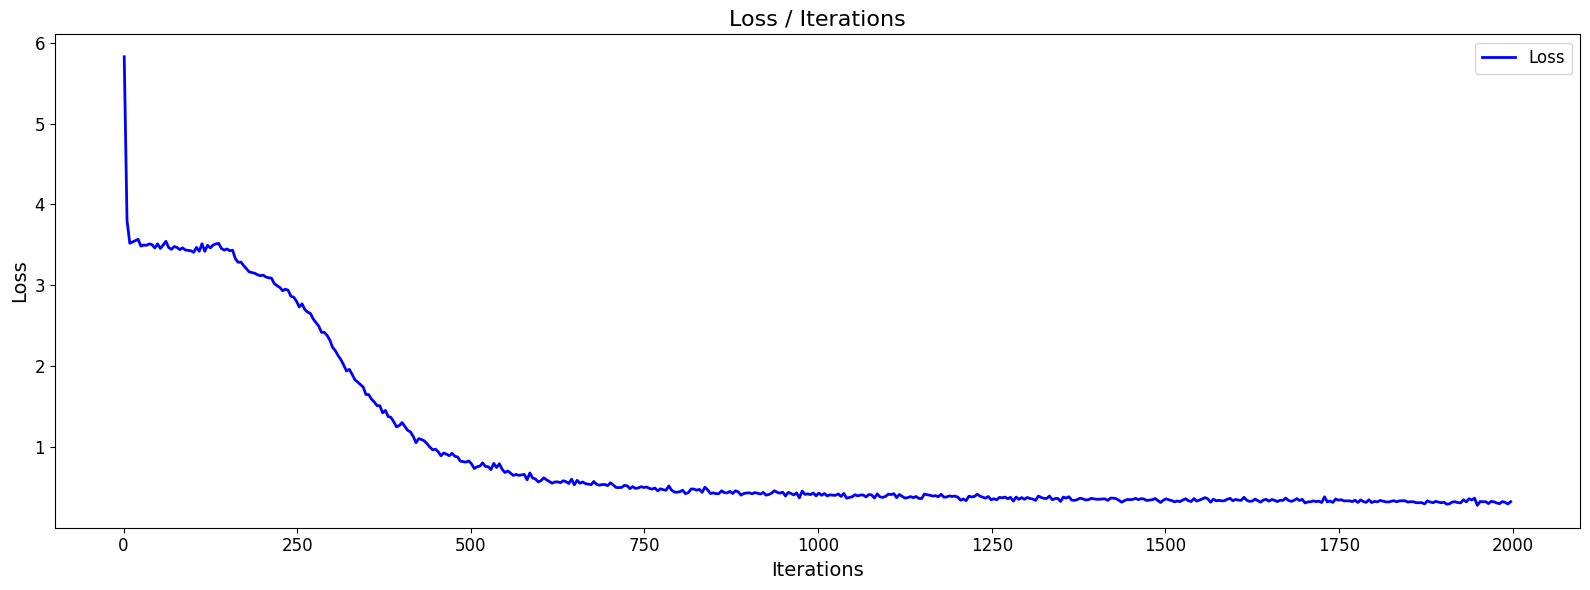

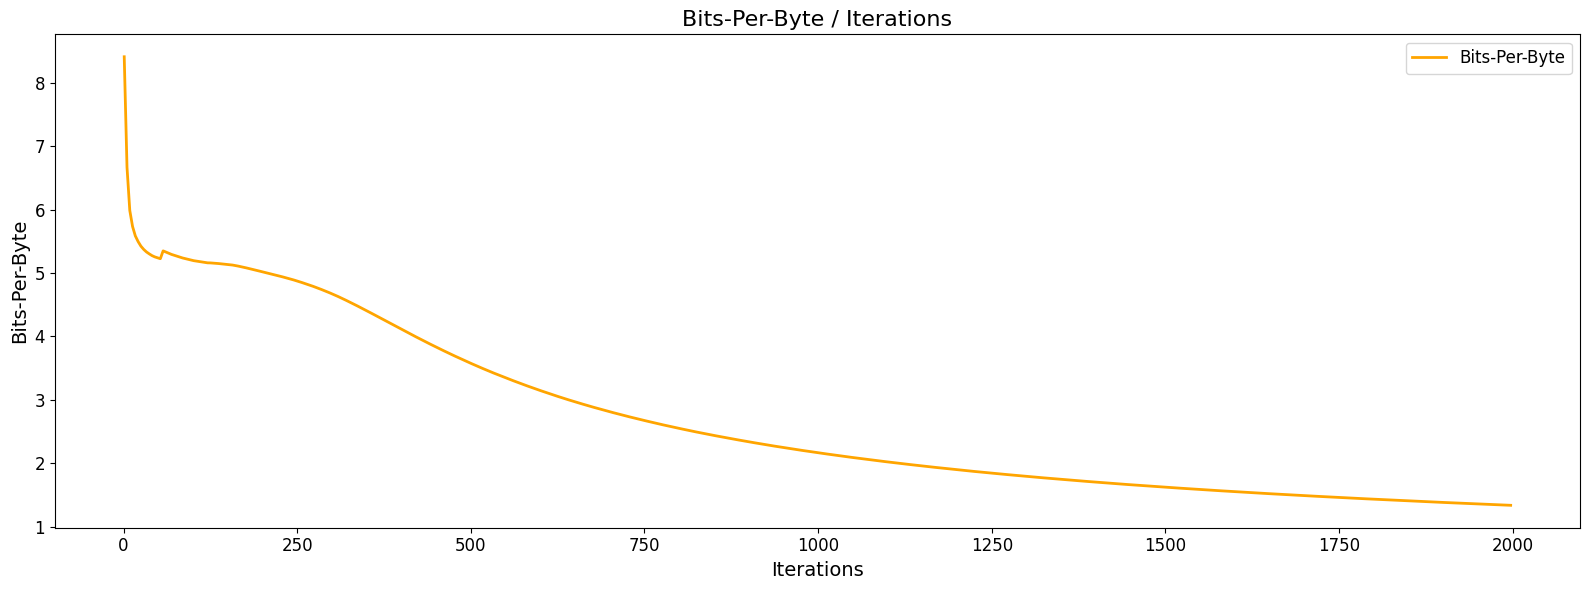

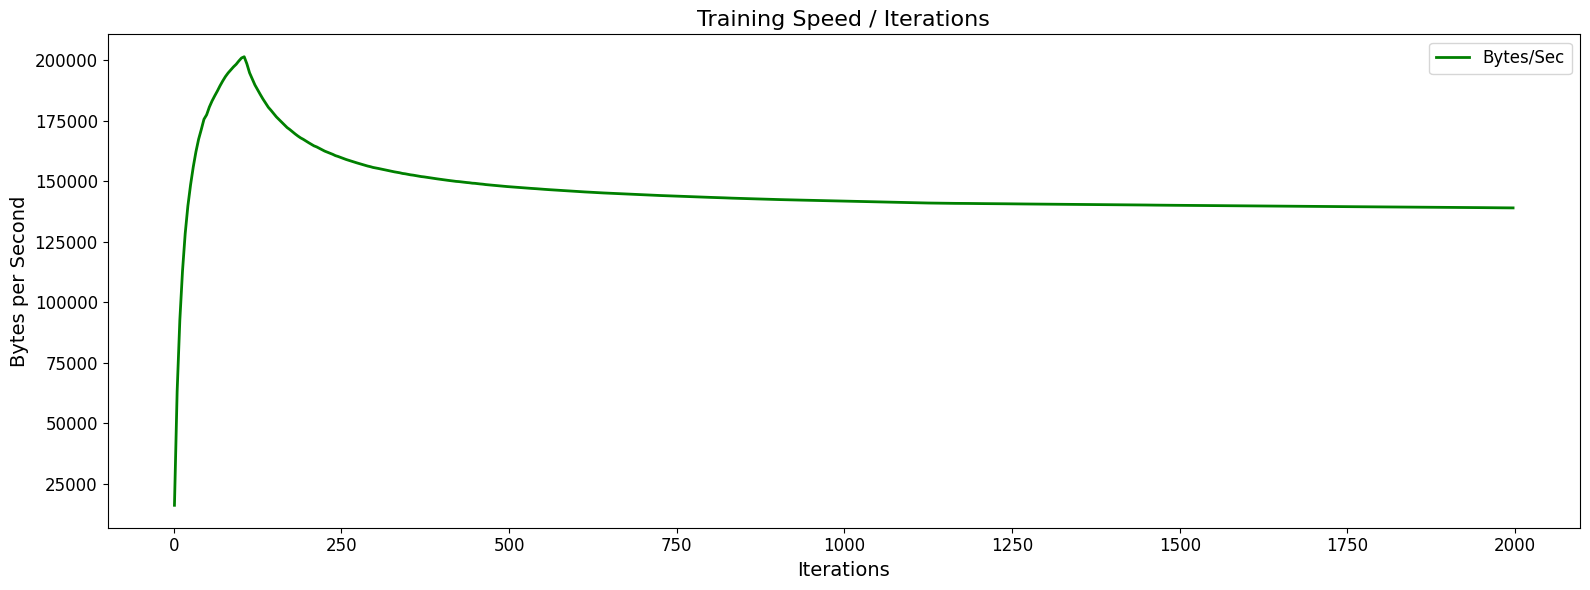

In [16]:
# Train model
model, dataset = train_model()


In [22]:
# Print Model's summary size and so on
print(model)
print(f"Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    



ByteLatentTransformer(
  (local_encoder): LocalEncoder(
    (byte_embedding): Embedding(256, 128)
    (hash_ngram): HashNGramEmbedding(
      (hash_embeddings): ModuleDict(
        (hash_3): Embedding(50000, 128)
        (hash_4): Embedding(50000, 128)
        (hash_5): Embedding(50000, 128)
      )
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x Block(
        (ln1): LayerNorm()
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (ln2): LayerNorm()
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (cross_attn): CrossAttentionLayer(
      (ln_q): LayerNorm()
      (ln_kv): LayerNorm()
      (attn): MultiheadAttention(
        (out_proj): NonDynamicall

In [17]:

if model is not None:
    # Sample from trained model
    prompt = "Once upon a"
    generated = generate(model, prompt)
    print(f"{prompt} {generated}")

Once upon a ccaifickigg.
Picchiefi ynochhis
escock
Witopops upon mypicio.
Speak
RUMEdicres kind;
ndishfpies abous hings isgd speak ister:
What?
Rsque pick'dst was heir
JUuncshalirst,
Pierince, seiiny:
Thexericise wild throney, he shown
Cighting,
sift
Butable house.
RICHSA:Where he has sharossmenking,
 picdius may chastise mereisveve the serious highs dedrechs such sinessA sse burishev in
Tfain'd her differe serifould
The thus stible thein docury past nowers indigithee,
Under be garden'd wi
